In [1]:
import pandas as pd
import numpy as np
import string as s
import seaborn as sns
import math
import tables
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style, colors
from itertools import groupby
import matplotlib.patches as patches
from matplotlib import gridspec
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
from scipy.ndimage.interpolation import shift
# matplotlib.style.use('ggplot')
# %matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
# matplotlib.rcParams['figure.facecolor'] = 'white'
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
matplotlib.style.use('ggplot')
%matplotlib inline




questions for Misha:
repressive marks: H3K9me3 and H3K27me3
broad marks: H3K4me1, H3K9me3, H3K27me3, H3K36me3
1. for 6 marks: marks = "H3K4me1","H3K4me3","H3K9me3","H3K27me3","H3K36me3","H3K27ac", what regions am i supposed to look at. for example, for H3K4me3 and H3K4me1 and H3K27ac and H3K27me3(negative mark means gene not expressed), , I can look at putative promoter regions.
H3K9me3(repressive mark ), complex repetative  regions. leave for later, mark for repetative regions and genes important for development, 1 million regions, bin genome to 10kb bins remove 0 values and cluster on the whole genome   
H3K36me3, use gene body. ask file from Misha
H3K4me1 and H3K27ac() can cluster on enhancer and txn binding regions.

2. confirm my workflow are correct:
1) intersect bdg file with hg19v69_genes.TSS_2000.pc.bed
2) sum bdg values for each putative promoters and divide by region length (4000) to get average signal values. i should have integrated on the various bins, (end-start +1)*coverage. see if 0 or 1 based. also Alessia requested using jaccard value, basically i will need a segmenation bed file telling the regions are enriched and then get the jaccard value while overlap enriched regions and putative promoter regions or gene body. 
3) cluster 


In [ ]:
questions for Misha:
repressive marks: H3K9me3 and H3K27me3
broad marks: H3K4me1, H3K9me3, H3K27me3, H3K36me3
1. for 6 marks: marks = "H3K4me1","H3K4me3","H3K9me3","H3K27me3","H3K36me3","H3K27ac", what regions am i supposed to look at. for example, for H3K4me3 and H3K4me1 and H3K27ac and H3K27me3(negative mark means gene not expressed), , I can look at putative promoter regions.
H3K9me3(repressive mark ), complex repetative  regions. leave for later, mark for repetative regions and genes important for development, 1 million regions, bin genome to 10kb bins remove 0 values and cluster on the whole genome   
H3K36me3, use gene body. ask file from Misha
H3K4me1 and H3K27ac() can cluster on enhancer and txn binding regions.

2. confirm my workflow are correct:
1) intersect bdg file with hg19v69_genes.TSS_2000.pc.bed
2) sum bdg values for each putative promoters and divide by region length (4000) to get average signal values. i should have integrated on the various bins, (end-start +1)*coverage. see if 0 or 1 based. also Alessia requested using jaccard value, basically i will need a segmenation bed file telling the regions are enriched and then get the jaccard value while overlap enriched regions and putative promoter regions or gene body. 
3) cluster 


# intersect treatment with TSS+-2kb

In [125]:
# command used to instersect signals in putative promoter regions
# while read i;do /home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools intersect -a ../hg19v69_genes.TSS_2000.pc.bed -b /projects/seqdev/DA-77/new_pipeline_treatment/step2/$i -wa -wb > $i.intersected;done < ../all_sorted_treat_pileup_bdg_files_names.txt


In [56]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/'

get meta data about library ids, hiv status, histology, total reads sequenced etc

In [57]:
f = '/home/szong/projects/META_2018/Master_Sample_table_14X292_Feb27_2018_sz.xls'
meta = pd.read_excel(f, sheetname='HTMCP CaCx epi')
meta.head(2)

,Order,Biospecimen ID,HIV status,Epigenome modifier mutation status,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,...,H3K4me3 % aligned,H3K9me3 % aligned,H3K27me3 % aligned,H3K36me3 % aligned,H3K27ac % aligned,input DNA control % aligned,internal sample ID,pool ID,Notes,# lanes 7 PE
0,1,HTMCP-03-06-02007-01A,negative,mutated,A84624,A84625,A84626,A84627,A84628,A84629,...,98.13,93.1,97.93,98.57,98.10,96.26,NaN,IX5978,NaN,1
1,2,HTMCP-03-06-02026-01A,negative,mutated,A84645,A84646,A84647,A84648,A84649,A84650,...,97.68,93.89,97.84,98.17,97.86,95.56,NaN,IX5981,NaN,1


In [58]:
meta = meta[['Biospecimen ID', 'H3K4me1 library ID',
       'H3K4me3 library ID', 'H3K9me3 library ID', 'H3K27me3 library ID',
       'H3K36me3 library ID', 'H3K27ac library ID',
       'input DNA control  library ID',  'H3K4me1 total reads', 'H3K4me3  total reads',
       'H3K9me3 total reads', 'H3K27me3 total reads', 'H3K36me3 total reads',
       'H3K27ac total reads', 'input DNA control  total reads']].dropna()

In [59]:
meta.head(2)

,Biospecimen ID,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,input DNA control library ID,H3K4me1 total reads,H3K4me3 total reads,H3K9me3 total reads,H3K27me3 total reads,H3K36me3 total reads,H3K27ac total reads,input DNA control total reads
0,HTMCP-03-06-02007-01A,A84624,A84625,A84626,A84627,A84628,A84629,A84630,78611726,60179836,76557498,90312752.0,106610232.0,80676254.0,86539886.0
1,HTMCP-03-06-02026-01A,A84645,A84646,A84647,A84648,A84649,A84650,A84651,85566812,74487212,93042922,89559600.0,87905340.0,84986034.0,88575282.0


In [60]:
meta['patient'] = meta['Biospecimen ID'].apply(lambda x: '-'.join(['HTMCP-03-06', x.split('-')[3]]))

In [61]:
meta = meta.drop('Biospecimen ID', axis=1)

In [62]:
meta.head(2)

,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,input DNA control library ID,H3K4me1 total reads,H3K4me3 total reads,H3K9me3 total reads,H3K27me3 total reads,H3K36me3 total reads,H3K27ac total reads,input DNA control total reads,patient
0,A84624,A84625,A84626,A84627,A84628,A84629,A84630,78611726,60179836,76557498,90312752.0,106610232.0,80676254.0,86539886.0,HTMCP-03-06-02007
1,A84645,A84646,A84647,A84648,A84649,A84650,A84651,85566812,74487212,93042922,89559600.0,87905340.0,84986034.0,88575282.0,HTMCP-03-06-02026


In [63]:
# add in hiv status and histology
f22 ='/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/mutation_load_clinic.txt'
df22 = pd.read_csv(f22, sep='\t')
df22 = df22[['patient', 'HIV_status', 'Putative_histology']]
# df22 = df22.set_index('patient')#.stack().reset_index()
df22.head(2)

,patient,HIV_status,Putative_histology
0,HTMCP-03-06-02001,Positive,Squamous
1,HTMCP-03-06-02002,Negative,Squamous


In [64]:
df_meta = pd.merge(meta, df22, left_on='patient', right_on='patient')
df_meta.head(2)

,H3K4me1 library ID,H3K4me3 library ID,H3K9me3 library ID,H3K27me3 library ID,H3K36me3 library ID,H3K27ac library ID,input DNA control library ID,H3K4me1 total reads,H3K4me3 total reads,H3K9me3 total reads,H3K27me3 total reads,H3K36me3 total reads,H3K27ac total reads,input DNA control total reads,patient,HIV_status,Putative_histology
0,A84624,A84625,A84626,A84627,A84628,A84629,A84630,78611726,60179836,76557498,90312752.0,106610232.0,80676254.0,86539886.0,HTMCP-03-06-02007,Negative,Adeno
1,A84645,A84646,A84647,A84648,A84649,A84650,A84651,85566812,74487212,93042922,89559600.0,87905340.0,84986034.0,88575282.0,HTMCP-03-06-02026,Negative,Adeno


In [65]:
df_meta.shape

(35, 17)

process chipseq signals

In [12]:
def get_files(f):
    # f = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/sorted_UCSC_A84611_H3K4me3_treat_pileup.bdg.intersected'
    df = pd.read_csv(f,header=None)
    df.columns = ['file']
    df.head(2)
    return df


In [13]:
def sum_signals(f):
    # f = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/sorted_UCSC_A84611_H3K4me3_treat_pileup.bdg.intersected'
    df = pd.read_csv(f, sep='\t', header=None)
    df.columns = ['chr', 'start', 'end', 'gene', 'chip_chr', 'chip_start', 'chip_end', 'peak_height']
    dfg = df.groupby(['chr', 'start', 'end', 'gene'])['peak_height'].sum().reset_index()
    of = '{0}.{1}'.format(f, 'sum')
    dfg.to_csv(of, index=False)


In [16]:

def process_signals(f1):
#     f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/treat_pileup_files.txt' 
    for idx, f in df1.iterrows():
        f = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/{}.intersected'.format(f['file'])
        sum_signals(f)

In [122]:
marks = ["H3K4me1",
"H3K4me3",
"H3K9me3",
"H3K27me3",
"H3K36me3",
"H3K27ac"
]

In [19]:
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/treat_pileup_files.txt'
df1 = get_files(f1)
process_signals(f1)

In [20]:
# process control, sum signals
f2 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/control_files.txt'
df2 = get_files(f2)
# process_signals(f2)

In [21]:
df3 = pd.merge(df1, df2, left_index=True, right_index=True)
df3.head(2)

,file_x,file_y
0,sorted_UCSC_A84611_H3K4me3_treat_pileup.bdg,sorted_UCSC_A84611_H3K4me3_control_lambda.bdg
1,sorted_UCSC_A84618_H3K4me3_treat_pileup.bdg,sorted_UCSC_A84618_H3K4me3_control_lambda.bdg


In [24]:
def visulize_control_treat_signal():
    # scatter plot to visualize treat vs control signal 
    num_pats = df3.shape[0]
    plt_per_row = 8
    nrow = math.floor(num_pats/plt_per_row)+1

    fig, axes = plt.subplots(nrow, plt_per_row, sharex='col', sharey='row', figsize=(2*plt_per_row, nrow*2))
    for idx, f in df3.iterrows():
        f4 = '{0}{1}.intersected.sum'.format(wkdir, f['file_x'])
        library = f['file_x'].split('_')[2]
        f5 = '{0}{1}.intersected.sum'.format(wkdir, f['file_y'])
        df4 = pd.read_csv(f4).set_index(['chr', 'start', 'end', 'gene'])
        df5 = pd.read_csv(f5).set_index(['chr', 'start', 'end', 'gene'])
        dfm = pd.merge(df4, df5, left_index=True, right_index=True)
    #     print(dfm.head(2))
        axrow = math.floor(idx/plt_per_row)
        axcol = idx%plt_per_row
        ax = axes[axrow, axcol]
        sns.regplot(x = 'peak_height_y', y = 'peak_height_x',fit_reg=False, ax=ax, data = dfm)
        ax.set(xlabel='control', ylabel='treat')
        ax.set(xlim=(0, 200000), ylim=(0, 300000))
        ax.text(50000, 250000, library)
    plt.suptitle('H3K4me3_bdg_sum_control_vs_treat', fontsize=14)  
    plt.tight_layout()
    of = '{}H3K4me3_bdg_sum_control_vs_treat.png'.format(wkdir)
    plt.savefig(of, dpi=200, box_inches='tight')
    plt.show()


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


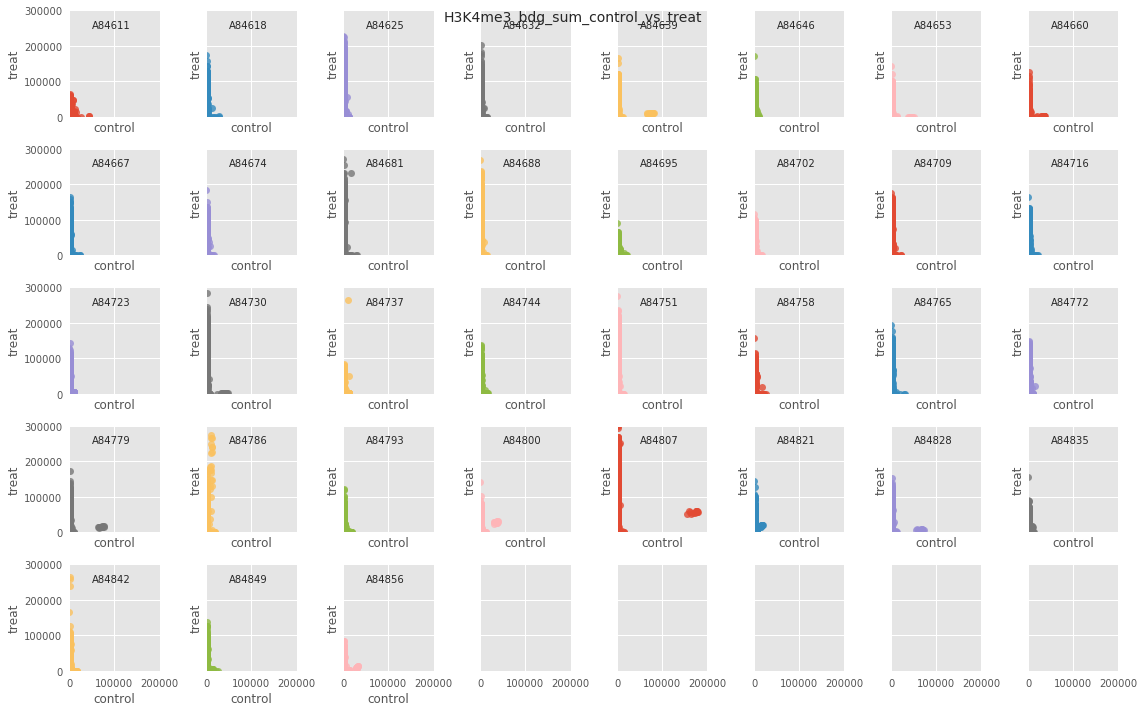

In [25]:
visulize_control_treat_signal()

merge signals from all libraries into matrix

In [26]:
def merge_data(df):
    dfm = pd.DataFrame()
    for idx, f in df.iterrows():
        f1 = '{0}{1}.intersected.sum'.format(wkdir, f['file_x'])
#         library = '_'.join(f['file_y'].split('_')[2:5])
        library = f['file_x'].split('_')[2]
        df1 = pd.read_csv(f1).set_index(['chr', 'start', 'end', 'gene'])
        df1.columns = [library]
        if dfm.empty:
            dfm = df1.copy()
        else:
            dfm = pd.merge(dfm, df1, left_index=True, right_index=True)
    return dfm
 

unsupervised clustering based on mean promoter H3K4me3 signal

In [27]:
df31 = pd.DataFrame(df3.file_x)
dfm = merge_data(df31)
dfm = dfm/4000 # length of the promoter regaion
dfm.head()

A84611   A84618   A84625   A84632  \
chr  start  end    gene                                                  
chr1 34081  38080  ENSG00000237613  0.22200  0.15125  0.20700  0.10825   
     67092  71091  ENSG00000186092  0.07875  0.01600  0.00800  0.00875   
     365641 369640 ENSG00000235249  0.01950  0.00375  0.00100  0.01125   
     620053 624052 ENSG00000185097  0.01975  0.00600  0.00125  0.00225   
     858261 862260 ENSG00000187634  1.37200  3.55250  4.88900  2.59675   

                                     A84639   A84646   A84653   A84660  \
chr  start  end    gene                                                  
chr1 34081  38080  ENSG00000237613  0.12800  0.13775  0.37925  0.05100   
     67092  71091  ENSG00000186092  0.03425  0.01400  0.01150  0.12725   
     365641 369640 ENSG00000235249  0.00300  0.02850  0.07375  0.00750   
     620053 624052 ENSG00000185097  0.00425  0.01950  0.06450  0.01350   
     858261 862260 ENSG00000187634  2.20700  1.97525  1.43975  0.73825   

                                     A84667   A84674   ...      A84786  \
chr  start  end    gene                                ...               
chr1 34081  38080  ENSG00000237613  0.10325  0.47225   ...     0.19400   
     67092  71091  ENSG00000186092  0.03450  0.03650   ...     0.18950   
     365641 369640 ENSG00000235249  0.01250  0.00300   ...     0.01225   
     620053 624052 ENSG00000185097  0.00725  0.00625   ...     0.00450   
     858261 862260 ENSG00000187634  1.69950  1.20775   ...     1.21950   

                                     A84793   A84800   A84807   A84821  \
chr  start  end    gene                                                  
chr1 34081  38080  ENSG00000237613  0.07875  0.13100  0.03300  0.08125   
     67092  71091  ENSG00000186092  0.03900  0.02350  0.05225  0.00950   
     365641 369640 ENSG00000235249  0.01400  0.00625  0.00325  0.00325   
     620053 624052 ENSG00000185097  0.03150  0.00300  0.01300  0.00575   
     858261 862260 ENSG00000187634  1.46650  1.75375  8.80250  0.79725   

                                     A84828   A84835   A84842   A84849  \
chr  start  end    gene                                                  
chr1 34081  38080  ENSG00000237613  0.70975  0.02425  0.01975  0.16250   
     67092  71091  ENSG00000186092  0.03425  0.00650  0.01075  0.02650   
     365641 369640 ENSG00000235249  0.00700  0.00450  0.00650  0.02125   
     620053 624052 ENSG00000185097  0.00700  0.00650  0.00850  0.03025   
     858261 862260 ENSG00000187634  2.78100  1.72675  2.20150  1.93100   

                                     A84856  
chr  start  end    gene                      
chr1 34081  38080  ENSG00000237613  0.27625  
     67092  71091  ENSG00000186092  0.02400  
     365641 369640 ENSG00000235249  0.00575  
     620053 624052 ENSG00000185097  0.00275  
     858261 862260 ENSG00000187634  4.42825  

[5 rows x 35 columns]

In [68]:
df_meta1 = df_meta[['H3K4me3 library ID', 'patient']].set_index('H3K4me3 library ID')
d = df_meta1.to_dict()
# d

In [70]:
dfm.columns = dfm.columns.to_series().map(d['patient'])

In [39]:
# dfm2 = pd.merge(dfm.T, df_meta, left_index=True, right_on ='H3K4me3 library ID').set_index('patient').drop('H3K4me3 library ID', axis=1).T


/home/szong/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (4 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [115]:
dfm.head(2)

HTMCP-03-06-02001  HTMCP-03-06-02006  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            0.22200            0.15125   
     67092 71091 ENSG00000186092            0.07875            0.01600   

                                  HTMCP-03-06-02007  HTMCP-03-06-02012  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613              0.207            0.10825   
     67092 71091 ENSG00000186092              0.008            0.00875   

                                  HTMCP-03-06-02020  HTMCP-03-06-02026  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            0.12800            0.13775   
     67092 71091 ENSG00000186092            0.03425            0.01400   

                                  HTMCP-03-06-02040  HTMCP-03-06-02042  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            0.37925            0.05100   
     67092 71091 ENSG00000186092            0.01150            0.12725   

                                  HTMCP-03-06-02054  HTMCP-03-06-02058  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            0.10325            0.47225   
     67092 71091 ENSG00000186092            0.03450            0.03650   

                                        ...          HTMCP-03-06-02210  \
chr  start end   gene                   ...                              
chr1 34081 38080 ENSG00000237613        ...                     0.1940   
     67092 71091 ENSG00000186092        ...                     0.1895   

                                  HTMCP-03-06-02214  HTMCP-03-06-02202  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            0.07875             0.1310   
     67092 71091 ENSG00000186092            0.03900             0.0235   

                                  HTMCP-03-06-02182  HTMCP-03-06-02260  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            0.03300            0.08125   
     67092 71091 ENSG00000186092            0.05225            0.00950   

                                  HTMCP-03-06-02266  HTMCP-03-06-02268  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            0.70975            0.02425   
     67092 71091 ENSG00000186092            0.03425            0.00650   

                                  HTMCP-03-06-02320  HTMCP-03-06-02330  \
chr  start end   gene                                                    
chr1 34081 38080 ENSG00000237613            0.01975             0.1625   
     67092 71091 ENSG00000186092            0.01075             0.0265   

                                  HTMCP-03-06-02332  
chr  start end   gene                                
chr1 34081 38080 ENSG00000237613            0.27625  
     67092 71091 ENSG00000186092            0.02400  

[2 rows x 35 columns]

heatmap to visualize the data

In [73]:
# cmap = sns.light_palette('red', as_cmap=True)
# g = sns.clustermap(dfm2, cmap = cmap)
# plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# pass

/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


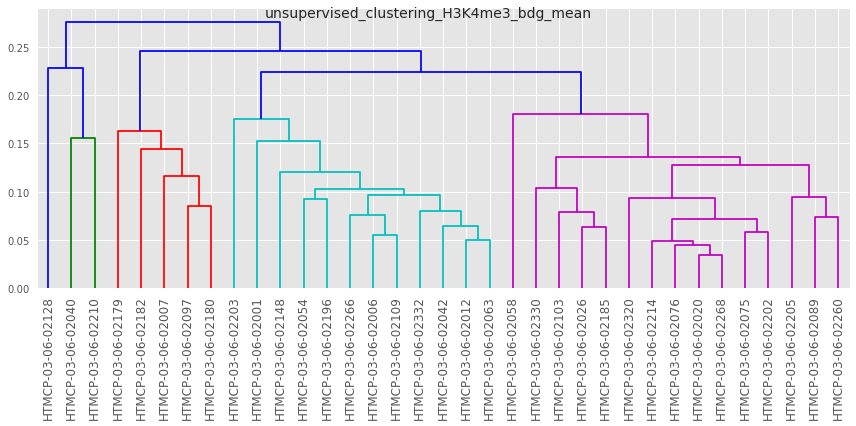

In [116]:
dfmm2 = dfm.copy()
np.isnan(dfmm2.values).any()
np.isinf(dfmm2.values).any()

# cluster by promoter signals so the array needs to be [number of patients, number of features]
matrix = dfmm2.values.T
matrix

dist='correlation'
link='ward'
Z = linkage(pdist(matrix, dist), link)

fig, ax = plt.subplots(figsize=(12,6))
aa = dendrogram(Z, leaf_rotation=90.,labels = dfmm2.columns,leaf_font_size=12.,show_contracted=True)#
plt.suptitle('unsupervised_clustering_H3K4me3_bdg_mean', fontsize=14)  
plt.tight_layout()
of = '{}unsupervised_clustering_H3K4me3_bdg_mean.png'.format(wkdir)
plt.savefig(of, dpi=200, box_inches='tight')

In [96]:
def get_track_df(dfm2):
    # get labels of the dendrogram and make track data frame
    # cluster by promoter signals so the array needs to be [number of patients, number of features]
    matrix = dfm2.values.T
    dist='correlation'
    link='ward'
    Z = linkage(pdist(matrix, dist), link)
    aa = dendrogram(Z, leaf_rotation=90.,labels = dfm2.columns,leaf_font_size=12.,show_contracted=True)
    den_labels = aa['ivl']
    adf = pd.DataFrame(den_labels)
    adf.columns = ['patient']
    df_track = pd.merge(adf, df_meta[['patient', 'HIV_status', 'Putative_histology' ]], left_on='patient', right_on='patient')#.drop(0, axis=1)
    df_track = df_track.set_index('patient')
    return df_track

In [95]:
adf = pd.DataFrame(den_labels)
adf['patient'] = adf[0].apply(lambda x: '-'.join(['HTMCP-03-06', x.split('-')[3]]))
adf = adf.drop(0, axis=1)
adf.head(2)

# cluster4: 11/15 are HIV+, cluster3: 8/12 are HIV-

,patient
0,HTMCP-03-06-02128
1,HTMCP-03-06-02040


In [79]:
df_track = pd.merge(adf, df_meta[['patient', 'HIV_status', 'Putative_histology' ]], left_on='patient', right_on='patient')#.drop(0, axis=1)
df_track.head(2)

,patient,HIV_status,Putative_histology
0,HTMCP-03-06-02128,Positive,Squamous
1,HTMCP-03-06-02040,Negative,Squamous


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


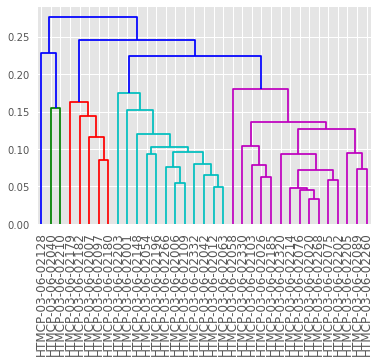

In [117]:
df_track = get_track_df(dfm)

In [98]:
df_track.head(2)

,HIV_status,Putative_histology
patient,,
HTMCP-03-06-02128,Positive,Squamous
HTMCP-03-06-02040,Negative,Squamous


plot hiv and histology track

In [84]:
clrs = ["purple", "#E69F00","#009E73","#56B4E9"]#,"#377EB8","#E41A1C","#F0E442",'black',"#D55E00","#CC79A7"]

In [85]:
# s = {k: d[k] for k in sorted(d, key=d.get, reverse=False)}
map_dict1 =  {'Adeno': 0.15,
 'Squamous': 0.25,
 'Negative': 0.35,
 'Positive': 0.45}


In [86]:
map_dict2 = {}
for n, k in enumerate(map_dict1.keys()):
    map_dict2[k] = clrs[n]
map_dict2

{'Adeno': 'purple',
 'Negative': '#009E73',
 'Positive': '#56B4E9',
 'Squamous': '#E69F00'}

In [87]:
assert list(map_dict2.values()) == clrs

In [88]:
df_track.head(2)

,patient,HIV_status,Putative_histology
0,HTMCP-03-06-02128,Positive,Squamous
1,HTMCP-03-06-02040,Negative,Squamous


In [99]:
ndf_track = df_track.apply(lambda x: x.map(map_dict1)).fillna(0).T
ndf_track.head(4)

patient,HTMCP-03-06-02128,HTMCP-03-06-02040,HTMCP-03-06-02210,HTMCP-03-06-02179,HTMCP-03-06-02182,HTMCP-03-06-02007,HTMCP-03-06-02097,HTMCP-03-06-02180,HTMCP-03-06-02203,HTMCP-03-06-02001,...,HTMCP-03-06-02320,HTMCP-03-06-02214,HTMCP-03-06-02076,HTMCP-03-06-02020,HTMCP-03-06-02268,HTMCP-03-06-02075,HTMCP-03-06-02202,HTMCP-03-06-02205,HTMCP-03-06-02089,HTMCP-03-06-02260
HIV_status,0.45,0.35,0.35,0.45,0.35,0.35,0.45,0.35,0.35,0.45,...,0.45,0.35,0.45,0.45,0.45,0.35,0.45,0.45,0.45,0.45
Putative_histology,0.25,0.25,0.25,0.15,0.15,0.15,0.25,0.25,0.15,0.25,...,0.25,0.25,0.25,0.25,0.25,0.15,0.25,0.25,0.25,0.25


In [100]:
legends = sorted(map_dict1, key=map_dict1.get, reverse=False)

In [101]:
dfm2.head(2)

patient,HTMCP-03-06-02001,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02012,HTMCP-03-06-02020,HTMCP-03-06-02026,HTMCP-03-06-02040,HTMCP-03-06-02042,HTMCP-03-06-02054,HTMCP-03-06-02058,...,HTMCP-03-06-02210,HTMCP-03-06-02214,HTMCP-03-06-02202,HTMCP-03-06-02182,HTMCP-03-06-02260,HTMCP-03-06-02266,HTMCP-03-06-02268,HTMCP-03-06-02320,HTMCP-03-06-02330,HTMCP-03-06-02332
"(chr1, 34081, 38080, ENSG00000237613)",0.22200,0.15125,0.207,0.10825,0.12800,0.13775,0.37925,0.05100,0.10325,0.47225,...,0.1940,0.07875,0.1310,0.03300,0.08125,0.70975,0.02425,0.01975,0.1625,0.27625
"(chr1, 67092, 71091, ENSG00000186092)",0.07875,0.01600,0.008,0.00875,0.03425,0.01400,0.01150,0.12725,0.03450,0.03650,...,0.1895,0.03900,0.0235,0.05225,0.00950,0.03425,0.00650,0.01075,0.0265,0.02400


In [104]:
len(dfm2.T.index)

35

/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 2.66 s, sys: 80 ms, total: 2.74 s
Wall time: 2.74 s


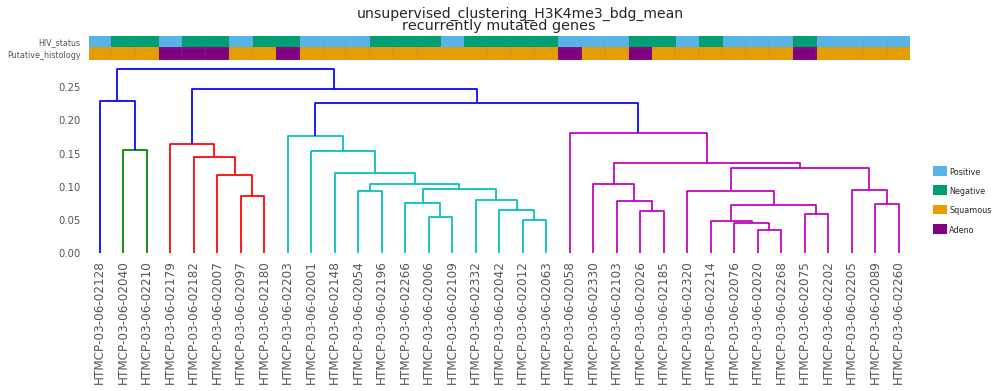

In [120]:
df = ndf_track.copy() # track df
# dfm: histone mark signal df
fig = plt.figure(figsize=(16, 4), facecolor='white')
gs = gridspec.GridSpec(2, 2, height_ratios=[1,8], width_ratios=[17,1], 
                       wspace=0.05, # horizontal space
                       hspace=0.0  # vertical space
                      )

bounds = np.arange(0.05, len(map_dict1)/10.0 + 0.1 , 0.1).tolist()
assert len(bounds) == len(map_dict1) + 1
# make a color map of fixed colors
cmap = colors.ListedColormap(clrs)
norm = colors.BoundaryNorm(bounds, cmap.N)
nrow = len(df.index)
ncol = len(df.columns)

ax1 = fig.add_subplot(gs[0])
img = ax1.imshow(df.values, interpolation='none', origin='upper', aspect='auto',
                    cmap=cmap, norm=norm)

_ = plt.yticks(np.arange(0, nrow, 1), df.index, fontsize=8)
_ = plt.xticks(np.arange(0, ncol, 1), df.columns, fontsize=8, rotation=90)

_ = ax1.set_yticks(np.arange(-.5, nrow, 1), minor=True);
_ = ax1.set_xticks(np.arange(-.5, ncol, 1), minor=True);

# Gridlines based on minor ticks
_ = ax1.grid(b=True, which='minor', color='gray', linestyle='--', linewidth=0.3)
# hide major tick grid
_ = ax1.grid(b=True, which='major', color='r', linestyle='-', linewidth=0)

ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.set_title('recurrently mutated genes')

# add dendrogram
ax3 = fig.add_subplot(gs[2], facecolor='white')
aa = dendrogram(Z, leaf_rotation=90.,labels = dfm.columns,leaf_font_size=12.,show_contracted=True)#
plt.suptitle('unsupervised_clustering_H3K4me3_bdg_mean', fontsize=14)  
# plt.tight_layout()

ax4 = fig.add_subplot(gs[3], facecolor='white')
# plot mutation legend
k = 1
for key in map_dict2:
    if key !=0: # don't plot key=0 which means no mutation
        clr = map_dict2[key]
        rect = patches.Rectangle((0,k/10), 0.3, 0.05, linewidth=0.01,edgecolor=clr,facecolor=clr)
        _ = ax4.text(0.35, k/10+.02, key, ha='left', va='center', fontsize=8)
        _ = ax4.add_patch(rect)
    k+=1
ax4.get_xaxis().set_ticks([])
ax4.get_yaxis().set_ticks([])

ax4.set_title('')


of = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/unsupervised_clustering_H3K4me3_bdg_mean.png'
%time plt.savefig(of, bbox_inches='tight',dpi=300)
plt.show()
plt.close()

In [112]:
dfm2.columns

Index(['HTMCP-03-06-02001', 'HTMCP-03-06-02006', 'HTMCP-03-06-02007',
       'HTMCP-03-06-02012', 'HTMCP-03-06-02020', 'HTMCP-03-06-02026',
       'HTMCP-03-06-02040', 'HTMCP-03-06-02042', 'HTMCP-03-06-02054',
       'HTMCP-03-06-02058', 'HTMCP-03-06-02109', 'HTMCP-03-06-02063',
       'HTMCP-03-06-02075', 'HTMCP-03-06-02076', 'HTMCP-03-06-02089',
       'HTMCP-03-06-02097', 'HTMCP-03-06-02103', 'HTMCP-03-06-02128',
       'HTMCP-03-06-02148', 'HTMCP-03-06-02179', 'HTMCP-03-06-02180',
       'HTMCP-03-06-02185', 'HTMCP-03-06-02196', 'HTMCP-03-06-02203',
       'HTMCP-03-06-02205', 'HTMCP-03-06-02210', 'HTMCP-03-06-02214',
       'HTMCP-03-06-02202', 'HTMCP-03-06-02182', 'HTMCP-03-06-02260',
       'HTMCP-03-06-02266', 'HTMCP-03-06-02268', 'HTMCP-03-06-02320',
       'HTMCP-03-06-02330', 'HTMCP-03-06-02332'],
      dtype='object', name='patient')

In [43]:
# df_track[df_track[0] == df_track['Biospecimen ID']]

In [236]:
df32 = pd.DataFrame(df3.file_y)
dfm2 = merge_data(df32)
dfm2 = dfm2/4000 # length of the promoter regaion
dfm2.head()

A84611_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.427685   
     67092  71091  ENSG00000186092                0.061214   
     365641 369640 ENSG00000235249                0.041954   
     620053 624052 ENSG00000185097                0.043833   
     858261 862260 ENSG00000187634                0.559055   

                                    A84618_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.310419   
     67092  71091  ENSG00000186092                0.055682   
     365641 369640 ENSG00000235249                0.009753   
     620053 624052 ENSG00000185097                0.019739   
     858261 862260 ENSG00000187634                0.287142   

                                    A84625_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.252474   
     67092  71091  ENSG00000186092                0.113265   
     365641 369640 ENSG00000235249                0.007909   
     620053 624052 ENSG00000185097                0.003780   
     858261 862260 ENSG00000187634                0.111270   

                                    A84632_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.204968   
     67092  71091  ENSG00000186092                0.049366   
     365641 369640 ENSG00000235249                0.034107   
     620053 624052 ENSG00000185097                0.044374   
     858261 862260 ENSG00000187634                0.226632   

                                    A84639_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.228736   
     67092  71091  ENSG00000186092                0.203678   
     365641 369640 ENSG00000235249                0.041958   
     620053 624052 ENSG00000185097                0.027462   
     858261 862260 ENSG00000187634                0.014630   

                                    A84646_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.146941   
     67092  71091  ENSG00000186092                0.133603   
     365641 369640 ENSG00000235249                0.016568   
     620053 624052 ENSG00000185097                0.020352   
     858261 862260 ENSG00000187634                0.094569   

                                    A84653_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.130224   
     67092  71091  ENSG00000186092                0.105407   
     365641 369640 ENSG00000235249                0.022140   
     620053 624052 ENSG00000185097                0.058604   
     858261 862260 ENSG00000187634                0.020124   

                                    A84660_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.237918   
     67092  71091  ENSG00000186092                0.316299   
     365641 369640 ENSG00000235249                0.013750   
     620053 624052 ENSG00000185097                0.044327   
     858261 862260 ENSG00000187634                0.032539   

                                    A84667_H3K4me3_control  \
chr  start  end    gene                                      
chr1 34081  38080  ENSG00000237613                0.352411   
     67092  71091  ENSG00000186092                0.073475   
     365641 369640 ENSG00000235249                0.018340   
     620053 624052 ENSG00000185097                0.017215   
     858261 862260 ENSG00000187634                0.262516   

                                    A84674_H3K4me3_control  \
chr  start  end    gene                                    